#**This notebook serializes the method for data preprocessing, training and evaluation of the models.**

**The code below this block Defines the Data preprocessing procedure, the training procedure and evaluation code. All the models utilize the same functions for obtaining the output. Please run all the blocks to successfully traing and evaluate the models.**

# Install Required Libraries


In [ ]:
!pip install torch torchvision scikit-learn matplotlib


# Preprocessing Pipeline Visualization
- Visualize the dataset preprocessing steps using a flowchart:
  - Start with raw CIFAR-10 images.
  - Steps include resizing, normalization, feature extraction (ResNet-18), and PCA reduction.



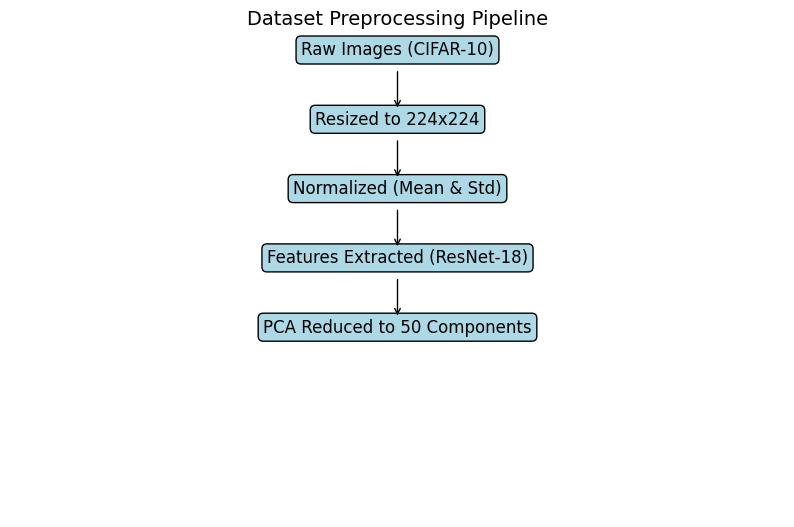

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a flowchart-like visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Define the steps
steps = [
    "Raw Images (CIFAR-10)",
    "Resized to 224x224",
    "Normalized (Mean & Std)",
    "Features Extracted (ResNet-18)",
    "PCA Reduced to 50 Components"
]

# Draw the flowchart
for i, step in enumerate(steps):
    ax.text(0.5, 1 - i * 0.15, step, fontsize=12, ha="center", bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Arrows
for i in range(len(steps) - 1):
    ax.annotate("", xy=(0.5, 1 - (i + 1) * 0.15 + 0.03), xytext=(0.5, 1 - i * 0.15 - 0.03), arrowprops=dict(arrowstyle="->", color="black"))

# Hide axes
ax.axis("off")
plt.title("Dataset Preprocessing Pipeline\n", fontsize=14)
plt.show()


# Feature Dimensions Visualization
- Compare feature dimensions at different stages:
  - After normalization (512 dimensions).
  - After PCA reduction (50 dimensions).
- A bar chart to show dimensions for training and testing datasets.


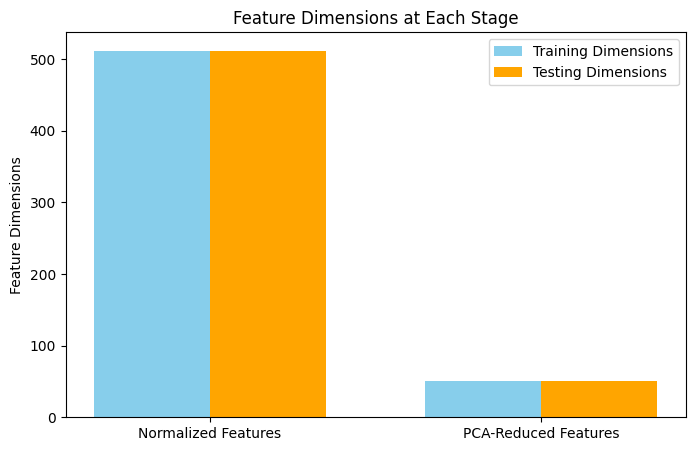

In [ ]:
import matplotlib.pyplot as plt

# Data for visualization
stages = ['Normalized Features', 'PCA-Reduced Features']
training_dims = [512, 50]
testing_dims = [512, 50]

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
x = range(len(stages))

ax.bar(x, training_dims, bar_width, label='Training Dimensions', color='skyblue')
ax.bar([p + bar_width for p in x], testing_dims, bar_width, label='Testing Dimensions', color='orange')

# Add labels, title, and legend
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(stages)
ax.set_ylabel('Feature Dimensions')
ax.set_title('Feature Dimensions at Each Stage')
ax.legend()

# Display the chart
plt.show()


# Library Imports and Setup
- Import necessary libraries
- Define the device (GPU/CPU) for computations.
- Check and display the available GPU.


In [ ]:
import torch
import pickle

from torchvision import datasets, transforms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if GPU is working
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))



def save_manual_naive_bayes(model, filename):
    """
    Saves the manual Naive Bayes model parameters to a file.

    Parameters:
    - model: The trained manual Naive Bayes model instance.
    - filename: The file path to save the model.
    """
    with open(filename, 'wb') as f:
        pickle.dump({
            'classes': model.classes,
            'mean': model.mean,
            'var': model.var,
            'priors': model.priors
        }, f)
    print(f'Manual Naive Bayes model saved to {filename}')

Using device: cpu


# CIFAR-10 Data Loading and Filtering
- Load CIFAR-10 dataset using PyTorch's `torchvision.datasets`.
- Preprocess:
  - Resize images to 224x224.
  - Normalize pixel values using CIFAR-10 mean and standard deviation.
- Filter to 500 training and 100 test images per class for balanced sampling.
- Return the filtered datasets and class names for visualization.


In [ ]:
def load_and_filter_cifar10():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # CIFAR-10 mean and std
    ])

    train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

    # Filter to 500 training and 100 test images per class
    train_data_by_class = {i: [] for i in range(10)}
    test_data_by_class = {i: [] for i in range(10)}

    for img, label in train_dataset:
        if len(train_data_by_class[label]) < 500:
            train_data_by_class[label].append((img, label))

    for img, label in test_dataset:
        if len(test_data_by_class[label]) < 100:
            test_data_by_class[label].append((img, label))

    #class names for mapping
    class_names = {
        0: "airplane",
        1: "automobile",
        2: "bird",
        3: "cat",
        4: "deer",
        5: "dog",
        6: "frog",
        7: "horse",
        8: "ship",
        9: "truck"
    }

    return train_data_by_class, test_data_by_class, class_names

# Load dataset
train_data_by_class, test_data_by_class, class_names = load_and_filter_cifar10()


100%|██████████| 170M/170M [00:06<00:00, 25.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Feature Extraction and Preprocessing
- Load a pre-trained ResNet-18 model.
- Extract high-level features by removing the classification head.
- Normalize extracted features and reduce dimensionality using PCA.
- Prepare `reduced_train_features` and `reduced_test_features` for training.


In [ ]:
from torchvision.models import resnet18
import torch.nn as nn

def extract_and_preprocess_features(data_by_class, device):
    # Load ResNet-18
    resnet = resnet18(weights="IMAGENET1K_V1").to(device)
    resnet = nn.Sequential(*list(resnet.children())[:-1])  # Remove classification head

    # Extract Features
    features, labels = [], []
    with torch.no_grad():
        for class_images in data_by_class.values():
            for img, label in class_images:
                img = img.unsqueeze(0).to(device)  # Add batch dimension
                feature = resnet(img).squeeze().cpu().numpy()
                features.append(feature)
                labels.append(label)

    # Normalize
    features = np.array(features)
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    features_normalized = (features - mean) / std

    return features_normalized, np.array(labels)

# Train and Test Features
train_features_normalized, y_train = extract_and_preprocess_features(train_data_by_class, device)
test_features_normalized, y_test = extract_and_preprocess_features(test_data_by_class, device)

# Apply PCA
pca = PCA(n_components=50, random_state=42)
reduced_train_features = pca.fit_transform(train_features_normalized)
reduced_test_features = pca.transform(test_features_normalized)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s]


#Naive Bayes Training and Evaluation
- Implement both manual and Scikit-learn Naive Bayes classifiers.
- Train both models using preprocessed CIFAR-10 features.
- Evaluate models
- Measure and display training times for both implementations.


Manual Naive Bayes Training Time: 0.27 seconds
Scikit-learn Naive Bayes Training Time: 0.03 seconds
Manual Naive Bayes Accuracy: 0.35
Manual Naive Bayes Classification Report:
              precision    recall  f1-score   support

    airplane       0.38      0.34      0.36       100
  automobile       0.49      0.50      0.50       100
        bird       0.36      0.23      0.28       100
         cat       0.14      0.11      0.12       100
        deer       0.21      0.29      0.25       100
         dog       0.36      0.34      0.35       100
        frog       0.27      0.45      0.34       100
       horse       0.42      0.37      0.39       100
        ship       0.51      0.36      0.42       100
       truck       0.43      0.49      0.46       100

    accuracy                           0.35      1000
   macro avg       0.36      0.35      0.35      1000
weighted avg       0.36      0.35      0.35      1000



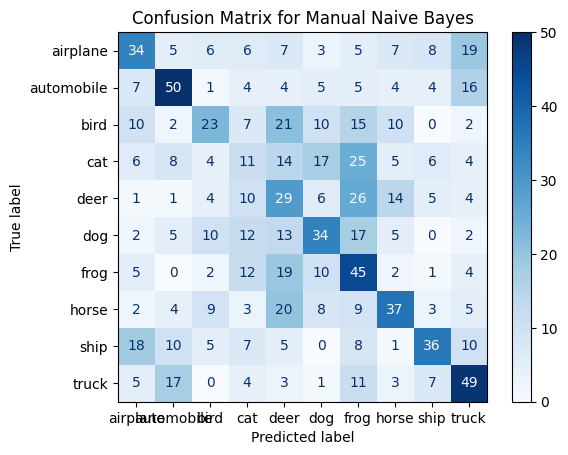

Scikit-learn Naive Bayes Accuracy: 0.35
Scikit-learn Naive Bayes Classification Report:
              precision    recall  f1-score   support

    airplane       0.38      0.34      0.36       100
  automobile       0.49      0.50      0.50       100
        bird       0.36      0.23      0.28       100
         cat       0.14      0.11      0.12       100
        deer       0.21      0.29      0.25       100
         dog       0.36      0.34      0.35       100
        frog       0.27      0.45      0.34       100
       horse       0.42      0.37      0.39       100
        ship       0.51      0.36      0.42       100
       truck       0.43      0.49      0.46       100

    accuracy                           0.35      1000
   macro avg       0.36      0.35      0.35      1000
weighted avg       0.36      0.35      0.35      1000



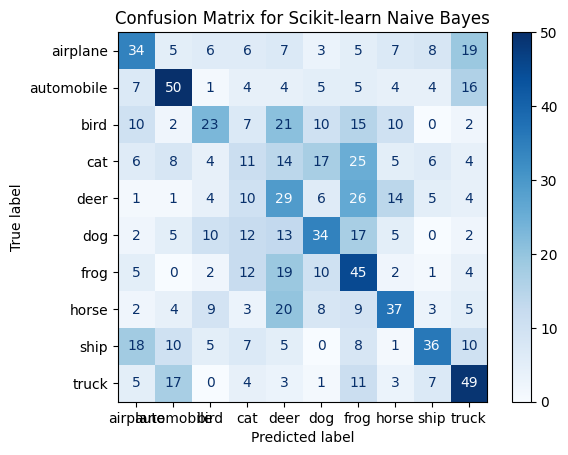

Summary of Training Times:
Manual Naive Bayes: 0.27 seconds
Scikit-learn Naive Bayes: 0.03 seconds


In [ ]:
import time

# Timing for Manual Naive Bayes Implementation
start_time_manual = time.time()

# Manual Naive Bayes Implementation
class GaussianNaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        self.var = np.zeros((len(self.classes), X.shape[1]), dtype=np.float64)
        self.priors = np.zeros(len(self.classes), dtype=np.float64)
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0)
            self.priors[idx] = X_c.shape[0] / float(X.shape[0])
    def predict(self, X):
        return np.array([self._predict(x) for x in X])
    def _predict(self, x):
        posteriors = []
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])
            likelihood = np.sum(np.log(self._pdf(idx, x)))
            posteriors.append(prior + likelihood)
        return self.classes[np.argmax(posteriors)]
    def _pdf(self, class_idx, x):
        mean, var = self.mean[class_idx], self.var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

# Fit and Predict for Manual Naive Bayes
manual_nb = GaussianNaiveBayes()
manual_nb.fit(reduced_train_features, y_train)
y_pred_manual = manual_nb.predict(reduced_test_features)

end_time_manual = time.time()
manual_training_time = end_time_manual - start_time_manual
print(f"Manual Naive Bayes Training Time: {manual_training_time:.2f} seconds")

# Timing for Scikit-learn Naive Bayes
start_time_sklearn = time.time()

# Scikit-learn Naive Bayes Implementation
from sklearn.naive_bayes import GaussianNB
sklearn_nb = GaussianNB()
sklearn_nb.fit(reduced_train_features, y_train)
y_pred_sklearn = sklearn_nb.predict(reduced_test_features)

end_time_sklearn = time.time()
sklearn_training_time = end_time_sklearn - start_time_sklearn
print(f"Scikit-learn Naive Bayes Training Time: {sklearn_training_time:.2f} seconds")

# Function to Evaluate Models
def evaluate_model(y_true, y_pred, title="Model Evaluation", class_names=None):
    """
    Evaluate the model using accuracy, classification report, and confusion matrix.
    """
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {accuracy:.2f}")

    # Print classification report
    print(f"{title} Classification Report:")
    if class_names is not None:
        print(classification_report(y_true, y_pred, target_names=class_names))
    else:
        print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    if class_names is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {title}")
    plt.show()

# Evaluate Models
evaluate_model(y_test, y_pred_manual, title="Manual Naive Bayes", class_names=list(class_names.values()))
evaluate_model(y_test, y_pred_sklearn, title="Scikit-learn Naive Bayes", class_names=list(class_names.values()))

# Summary of Training Times
print(f"Summary of Training Times:")
print(f"Manual Naive Bayes: {manual_training_time:.2f} seconds")
print(f"Scikit-learn Naive Bayes: {sklearn_training_time:.2f} seconds")


#Save the Manual Naive Bayes Model
- Use the `pickle` library to save model parameters to a file.
- Save the trained manual model to "manual_naive_bayes.pkl" for future reuse.


In [ ]:
import pickle

def save_model(model, filename):
    """
    Saves the model parameters to a file.
    """
    with open(filename, 'wb') as f:
        pickle.dump({
            'classes': model.classes,
            'mean': model.mean,
            'var': model.var,
            'priors': model.priors
        }, f)
    print(f"Model saved to {filename}")

def load_model(model, filename):
    """
    Loads the saved parameters into the manual Naive Bayes model.
    """
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    model.classes = params['classes']
    model.mean = params['mean']
    model.var = params['var']
    model.priors = params['priors']
    print(f"Model loaded from {filename}")


#Training Time Visualization
- Compare training times of manual and Scikit-learn Naive Bayes models.
- Plot a bar chart for visual comparison of training times.


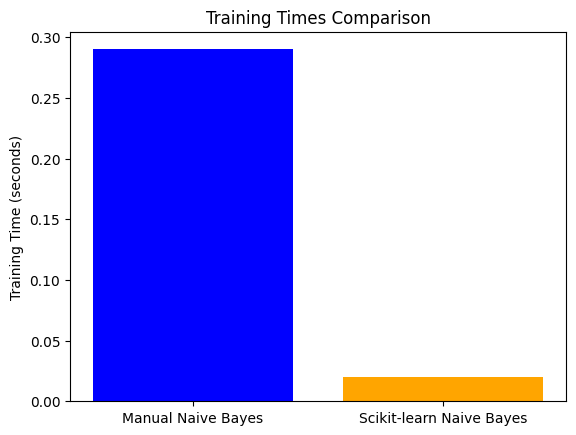

In [ ]:
import matplotlib.pyplot as plt

# Data
models = ['Manual Naive Bayes', 'Scikit-learn Naive Bayes']
times = [0.29, 0.02]

# Plot
plt.bar(models, times, color=['blue', 'orange'])
plt.ylabel('Training Time (seconds)')
plt.title('Training Times Comparison')
plt.show()
